In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arrow
from scipy.signal import savgol_filter 
import numpy as np
from lmfit.models import SkewedGaussianModel

In [2]:
# data from: http://ncov.mohw.go.kr/
df = pd.read_csv("all.csv").loc[1:].reset_index()
df["counts"] = [float(c.replace(",", "")) for c in df["계(명)"]]
df["savgol"] = savgol_filter([float(c.replace(",", "")) for c in df["계(명)"]], 7, 2)
df["ts"] = pd.to_datetime([str(arrow.get(t)) for t in df["일자"]])
df["rolling_avg"] = df["counts"].rolling(7).mean()
df.tail()

,index,일자,계(명),계(명).1,해외유입(명),사망(명),counts,savgol,ts,rolling_avg
808,809,2022.4.8,"205,333","205,325",8,373,205333.0,216087.904762,2022-04-08 00:00:00+00:00,229749.142857
809,810,2022.4.9,"185,566","185,526",40,338,185566.0,165285.333333,2022-04-09 00:00:00+00:00,218519.857143
810,811,2022.4.10,"164,481","164,454",27,329,164481.0,153711.285714,2022-04-10 00:00:00+00:00,208545.571429
811,812,2022.4.11,"90,928","90,907",21,258,90928.0,157221.500000,2022-04-11 00:00:00+00:00,203365.285714
812,813,2022.4.12,"210,755","210,741",14,171,210755.0,175815.976190,2022-04-12 00:00:00+00:00,195453.857143


In [3]:
df["weekday"] = [t.weekday() for t in df.ts]
df["counts_vs_rolling_avg"] = (df['counts'] - df['rolling_avg']) / df['rolling_avg']

df_for_weekdaytype = df[780:809].reset_index()
weekday_filter_weights = []
for weeknum in range(7):
    dat = df_for_weekdaytype.loc[df_for_weekdaytype.weekday == weeknum].counts_vs_rolling_avg.to_numpy()
    weekday_filter_weights.append(np.median(dat))
    
weekday_filter_weights

[-0.45984489044417665,
 -0.010375245588724536,
 0.19402192202001067,
 0.03203274687910064,
 -0.051317705233094146,
 -0.0510811275159606,
 -0.12838768882025478]

In [4]:
def skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=False, weighted=False, show_plots=True):
    """
    Parameters
    ----------
    target_y: univariate series to fit. 
    start_idx: start index
    df: whole dataframe
    show_stats: bool for plotting figs.
    weighted=False: bool for weighted fitting. If True, more recent data points get more weights on fitting. 
    
    """
    window_length = len(df) - start_idx
    april = pd.to_datetime([f"2022-04-{x}T00:00:00+00:00'" for x in range(1,31)]).to_list()
    may = pd.to_datetime([f"2022-05-{x}T00:00:00+00:00'" for x in range(1,32)]).to_list()
    whole_date = df["ts"].to_list() + april + may

    whole_date = sorted(list(set(whole_date)))
    xvals = np.arange(0, window_length)
    yvals = target_y[start_idx:]

    model = SkewedGaussianModel()

    # set initial parameter values
    params = model.make_params(amplitude=13639305., center=102.12, sigma=22.41, gamma=0)

    # adjust parameters  to best fit data.
    if weighted:
        result = model.fit(yvals, params, x=xvals, weights=xvals + 50)
    else:
        result = model.fit(yvals, params, x=xvals)
    
    if show_stats:
        print(result.fit_report())

    expected = result.eval(x=np.arange(-20, window_length+35))
    if show_plots:
        plt.figure(figsize=(6.5, 3))
        plt.title("fitting")
        plt.plot(xvals, yvals, 'd')
        ex = result.eval(x=xvals)
        plt.plot(xvals, ex)
        
        plt.figure(figsize=(8, 3))
        plt.plot(whole_date[start_idx-20:start_idx+window_length],  target_y[start_idx-20:], 'd', label="daily Covid cases")
        plt.plot(whole_date[start_idx-20:start_idx+window_length+35], expected, label="skewed gaussian fitting")
        plt.legend()
        plt.title("Forecasting Korean Covid cases")
        plt.xticks(whole_date[start_idx-20:start_idx+window_length+35][::15])
        
    return whole_date[start_idx-20:start_idx+window_length+35], target_y[start_idx-20:], expected


def weekday_filter(data, weeknum_series):
    filtered = []
    for data_single, weeknum in zip(data, weeknum_series):
        result = data_single * (weekday_filter_weights[weeknum]+1)
        filtered.append(result)
        
    return filtered
        
    

## 7-day rolling avg & original confirmed cases

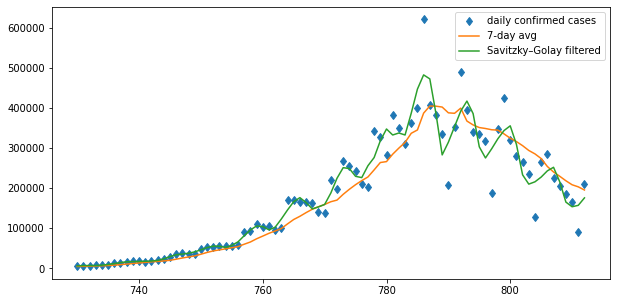

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df.counts[730:], 'd', label="daily confirmed cases")
df.rolling_avg[730:].plot(label="7-day avg")
df.savgol[730:].plot(label="Savitzky–Golay filtered")
plt.legend()

## skewed normal fifting using original data

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 231
    # data points      = 43
    # variables        = 4
    chi-square         = 1.9560e+11
    reduced chi-square = 5.0155e+09
    Akaike info crit   = 964.240731
    Bayesian info crit = 971.285532
[[Variables]]
    amplitude:  15232566.0 +/- 1010362.32 (6.63%) (init = 1.363930e+07)
    center:     5.17867980 +/- 2.67393874 (51.63%) (init = 102.12)
    sigma:      23.7585398 +/- 4.86579797 (20.48%) (init = 22.41)
    gamma:      2.13709596 +/- 1.35442888 (63.38%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.941
    C(sigma, gamma)      = 0.909
    C(center, gamma)     = -0.872
    C(amplitude, sigma)  = 0.561
    C(amplitude, center) = -0.505
    C(amplitude, gamma)  = 0.250
next day(2022-04-13 00:00:00+00:00) prediction: 171978


Text(0.5, 1.0, 'Predicting Covid cases in Korea')

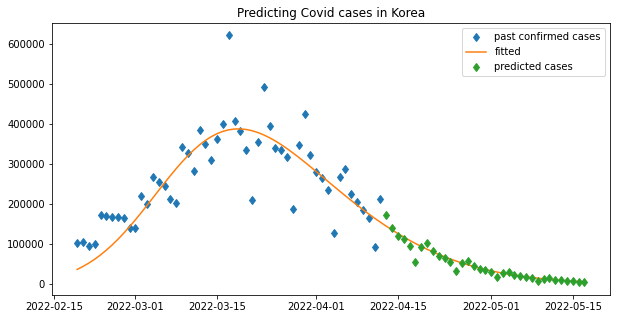

In [6]:
target_y = df.counts
start_idx = 770

x, y, y_expect = skewed_gaussian_fitting_n_plot(target_y, start_idx, df,
                                                show_stats=True,
                                                show_plots=False)

window_length = len(df) - start_idx
weekday_series = [t.weekday() for t in x]
filtered_data = weekday_filter(y_expect, weekday_series)

plt.figure(figsize=(10, 5))
plt.plot(x[10:len(y)], y[10:], 'd', label="past confirmed cases")
plt.plot(x[10:], y_expect[10:], label="fitted")
plt.plot(x[len(y):], filtered_data[len(y):], 'd', label='predicted cases')
plt.legend()

print(f"next day({x[len(y)]}) prediction:", int(filtered_data[len(y)]))
plt.title("Predicting Covid cases in Korea")

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 215
    # data points      = 43
    # variables        = 4
    chi-square         = 1.0083e+15
    reduced chi-square = 2.5855e+13
    Akaike info crit   = 1331.79333
    Bayesian info crit = 1338.83813
[[Variables]]
    amplitude:  15226317.7 +/- 1011340.65 (6.64%) (init = 1.363930e+07)
    center:     4.97563449 +/- 2.29776322 (46.18%) (init = 102.12)
    sigma:      24.1811971 +/- 4.18796380 (17.32%) (init = 22.41)
    gamma:      2.30025100 +/- 1.41583994 (61.55%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.899
    C(sigma, gamma)      = 0.862
    C(center, gamma)     = -0.724
    C(amplitude, center) = -0.511
    C(amplitude, sigma)  = 0.416
next day(2022-04-13 00:00:00+00:00) prediction: 174208


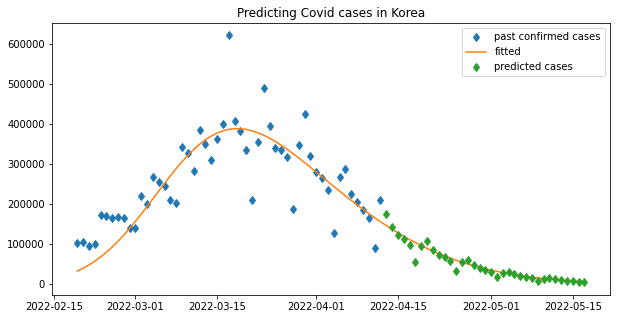

In [7]:
target_y = df.counts
start_idx = 770

x, y, y_expect = skewed_gaussian_fitting_n_plot(target_y, start_idx, df,
                                                show_stats=True,
                                                show_plots=False,
                                                weighted=True)

window_length = len(df) - start_idx
weekday_series = [t.weekday() for t in x]
filtered_data = weekday_filter(y_expect, weekday_series)

plt.figure(figsize=(10, 5))
plt.plot(x[10:len(y)], y[10:], 'd', label="past confirmed cases")
plt.plot(x[10:], y_expect[10:], label="fitted")
plt.plot(x[len(y):], filtered_data[len(y):], 'd', label='predicted cases')
plt.legend()
print(f"next day({x[len(y)]}) prediction:", int(filtered_data[len(y)]))
plt.title("Predicting Covid cases in Korea")
plt.savefig("figs/fitting_n_prediction.png", facecolor="w")

## skewed normal fifting using 7-day rolling avg

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 130
    # data points      = 43
    # variables        = 4
    chi-square         = 8.8900e+09
    reduced chi-square = 2.2795e+08
    Akaike info crit   = 831.320769
    Bayesian info crit = 838.365570
[[Variables]]
    amplitude:  15409415.4 +/- 270275.056 (1.75%) (init = 1.363930e+07)
    center:     9.00806477 +/- 1.27964695 (14.21%) (init = 102.12)
    sigma:      22.3742928 +/- 1.72694518 (7.72%) (init = 22.41)
    gamma:      1.56718304 +/- 0.33944863 (21.66%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.982
    C(center, gamma)     = -0.978
    C(sigma, gamma)      = 0.971
    C(amplitude, sigma)  = 0.738
    C(amplitude, center) = -0.668
    C(amplitude, gamma)  = 0.593


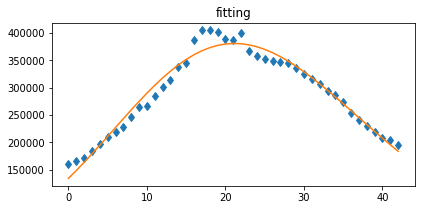

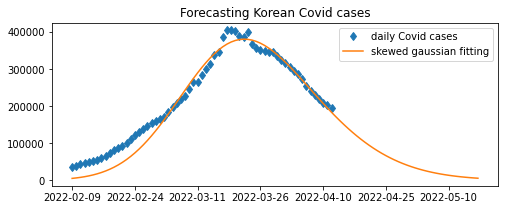

In [8]:
target_y = df.rolling_avg
start_idx = 770

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)
plt.show()

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 229
    # data points      = 43
    # variables        = 4
    chi-square         = 3.7796e+13
    reduced chi-square = 9.6912e+11
    Akaike info crit   = 1190.58687
    Bayesian info crit = 1197.63167
[[Variables]]
    amplitude:  15490029.3 +/- 226849.887 (1.46%) (init = 1.363930e+07)
    center:     8.14812506 +/- 0.78728894 (9.66%) (init = 102.12)
    sigma:      23.6285444 +/- 1.26052568 (5.33%) (init = 22.41)
    gamma:      1.86567875 +/- 0.29335574 (15.72%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.969
    C(sigma, gamma)      = 0.945
    C(center, gamma)     = -0.928
    C(amplitude, sigma)  = 0.653
    C(amplitude, center) = -0.635
    C(amplitude, gamma)  = 0.426


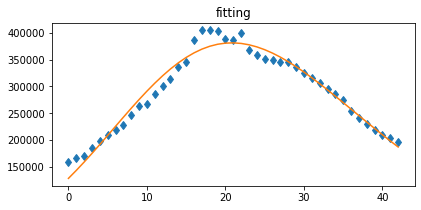

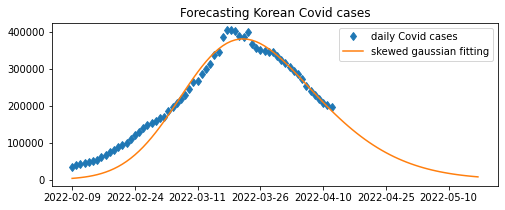

In [9]:
target_y = df.rolling_avg
start_idx = 770

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True, weighted=True)
plt.show()

## skewed normal fifting using Savitzky–Golay filtered signal

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 151
    # data points      = 43
    # variables        = 4
    chi-square         = 7.1448e+10
    reduced chi-square = 1.8320e+09
    Akaike info crit   = 920.934386
    Bayesian info crit = 927.979187
[[Variables]]
    amplitude:  15273327.3 +/- 615544.565 (4.03%) (init = 1.363930e+07)
    center:     5.11634893 +/- 1.59479436 (31.17%) (init = 102.12)
    sigma:      23.9160316 +/- 2.94610041 (12.32%) (init = 22.41)
    gamma:      2.16232610 +/- 0.82328781 (38.07%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.940
    C(sigma, gamma)      = 0.908
    C(center, gamma)     = -0.867
    C(amplitude, sigma)  = 0.568
    C(amplitude, center) = -0.513
    C(amplitude, gamma)  = 0.255


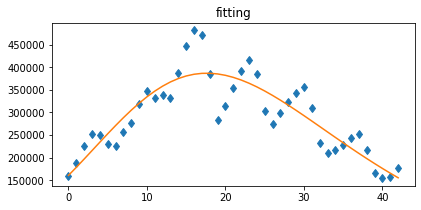

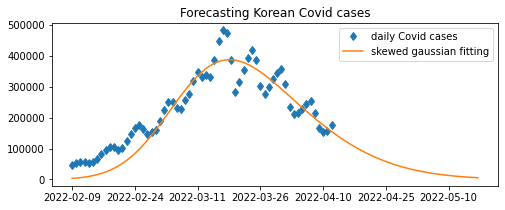

In [10]:
target_y = df.savgol
start_idx = 770

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)
plt.show()


[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 182
    # data points      = 43
    # variables        = 4
    chi-square         = 3.8838e+14
    reduced chi-square = 9.9584e+12
    Akaike info crit   = 1290.76752
    Bayesian info crit = 1297.81232
[[Variables]]
    amplitude:  15482353.3 +/- 703257.212 (4.54%) (init = 1.363930e+07)
    center:     18.8467196 +/- 101307.342 (537533.03%) (init = 102.12)
    sigma:      16.2933819 +/- 214.851777 (1318.64%) (init = 22.41)
    gamma:      0.01627541 +/- 7793.10098 (47882656.21%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma) = -1.000
    C(center, sigma) = -1.000
    C(sigma, gamma)  = 1.000


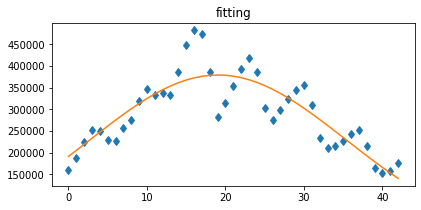

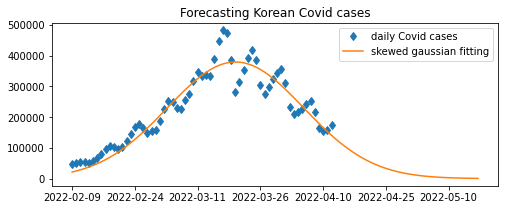

In [11]:
target_y = df.savgol
start_idx = 770

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True, weighted=True)
plt.show()